Write code to numerically solve a 2D Burger's Equation problem from x = 0 to x = 2π, y = 0 to y = 2π, using 100x100 node points (excluding ghost cells) and second-order central schemes for the advective and diffusive terms. Choose an initial condition that is suitable for discussing each term in Burger's equation.

The 2D viscous Burgers' equation is given by:
\begin{equation}
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y} = \nu \; \left(\frac{\partial ^2 u}{\partial x^2} + \frac{\partial ^2 u}{\partial y^2}\right)
\end{equation}
\begin{equation}
\frac{\partial v}{\partial t} + u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y} = \nu \; \left(\frac{\partial ^2 v}{\partial x^2} + \frac{\partial ^2 v}{\partial y^2}\right)
\end{equation}

where $u(x,y,t)$ and $v(x,y,t)$ are the velocity fields, $\nu$ is the kinematic viscosity, $t$ is time, and $x$ and $y$ are the spatial coordinate

The finite difference version of the equations are as follows:
$$
\begin{split}
u_{i,j}^{n+1} = & u_{i,j}^n - \frac{\Delta t}{\Delta x} u_{i,j}^n (u_{i,j}^n - u_{i-1,j}^n)  - \frac{\Delta t}{\Delta y} v_{i,j}^n (u_{i,j}^n - u_{i,j-1}^n) \\
&+ \frac{\nu \Delta t}{\Delta x^2}(u_{i+1,j}^n-2u_{i,j}^n+u_{i-1,j}^n) + \frac{\nu \Delta t}{\Delta y^2} (u_{i,j+1}^n - 2u_{i,j}^n + u_{i,j-1}^n)
\end{split}
$$

$$
\begin{split}
v_{i,j}^{n+1} = & v_{i,j}^n - \frac{\Delta t}{\Delta x} u_{i,j}^n (v_{i,j}^n - v_{i-1,j}^n) - \frac{\Delta t}{\Delta y} v_{i,j}^n (v_{i,j}^n - v_{i,j-1}^n) \\
&+ \frac{\nu \Delta t}{\Delta x^2}(v_{i+1,j}^n-2v_{i,j}^n+v_{i-1,j}^n) + \frac{\nu \Delta t}{\Delta y^2} (v_{i,j+1}^n - 2v_{i,j}^n + v_{i,j-1}^n)
\end{split}
$$

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [7]:
with open('2D_viscous_burgers_inputs.txt', 'r') as file:
        data = file.readlines()
        type = data[0].split(' = ')
        type = type[1].rstrip()
        order = data[1].split(' = ')
        order = order[1].rstrip()
        l = data[2].split(' = ')
        l = eval(l[1])
        n = data[3].split(' = ')
        n = eval(n[1])
        nu = data[4].split(' = ')
        nu = eval(nu[1])
        u0 = data[5].split(' = ')
        u0 = u0[1].rstrip()
        dt = data[6].split(' = ')
        dt = eval(dt[1])

print('problem type =', type)
print('order = ', order)
print('l = ', l)
print('nx = ', n)
print('nu = ', nu)
print('u0 = ', u0)
print('dt = ', dt)

problem type = convective
order =  second
l =  6.283185307179586
nx =  100
nu =  0.1
u0 =  sin
dt =  0.01


In [67]:
def diff_solver(l, nx, ny, nt, nu, dt, ic, order):
    # Grid generation
    # Ghost cell number based on order level
    if order == 'second order':
        ngc = 1
    elif order == 'forth ordr':
        ngc = 2
    elif order == 'sixth order':
        ngc = 3
    # Grid build
    x = np.linspace(0, l, nx, endpoint=False)
    y = np.linspace(0, l, ny, endpoint=False)

    u = np.empty((nx, ny))
    v = np.empty((nx, ny))
    
    # Initial condition
    if ic == 'sine':
        u[:, :] = np.sin(x)
        v[:, :] = np.sin(y)
    elif ic == 'sawtooth':
        u[:, :] = x/l - np.floor(x/l)
        v[:, :] = y/l - np.floor(y/l)
    elif ic == 'rarefaction':
        u[:, :] = 0.2*np.tanh(2*(x - 0.5))
        v[:, :] = 0.2*np.tanh(2*(y - 0.5))
    
    # ghost cell expansion
    u = np.concatenate((u[-ngc:], u, u[:ngc]))
    v = np.concatenate((v[-ngc:], v, v[:ngc]))
       
    un = np.empty((len(u), len(v)))
    vn = np.empty((len(u), len(v)))

    dx = l/(nx + 1)
    dy = l/(ny + 1)
        
    for i in range(nt):
        un = u.copy()
        vn = v.copy()
        
        u[1:-1, 1:-1] = (un[1:-1, 1:-1] -dt/dx*un[1:-1, 1:-1]*(un[1:-1, 1:-1] - un[1:-1, :-2]) 
                         - dt/dy*vn[1:-1, 1:-1]*(un[1:-1, 1:-1] - un[:-2, 1:-1]) + nu*dt/dx**2*(un[1:-1,2:] 
                         - 2*un[1:-1, 1:-1] + un[1:-1, :-2]) + nu*dt/dy**2*(un[2:, 1:-1] - 2*un[1:-1, 1:-1] + un[:-2, 1:-1]))
    
        v[1:-1, 1:-1] = (vn[1:-1, 1:-1] - dt/dx*un[1:-1, 1:-1]*(vn[1:-1, 1:-1] - vn[1:-1, :-2]) 
                         - dt/dy*vn[1:-1, 1:-1]*(vn[1:-1, 1:-1] - vn[:-2, 1:-1]) + nu*dt/dx**2*(vn[1:-1, 2:] 
                         - 2*vn[1:-1, 1:-1] + vn[1:-1, :-2]) + nu*dt/dy**2*(vn[2:, 1:-1] - 2*vn[1:-1, 1:-1] + vn[:-2, 1:-1]))
     
        u[0, :] = u[-1, :]
        u[:, 0] = u[:, -1]
    
        v[0, :] = v[-1, :]
        v[:, 0] = v[:, -1]
    
    return u, v

In [68]:
x = np.linspace(0, l, 100, endpoint=False)
y = np.linspace(0, l, 100, endpoint=False)

In [69]:
u, v = diff_solver(2*np.pi, 100, 100, 40, 0.1, 0.01, 'sine', 'second order')

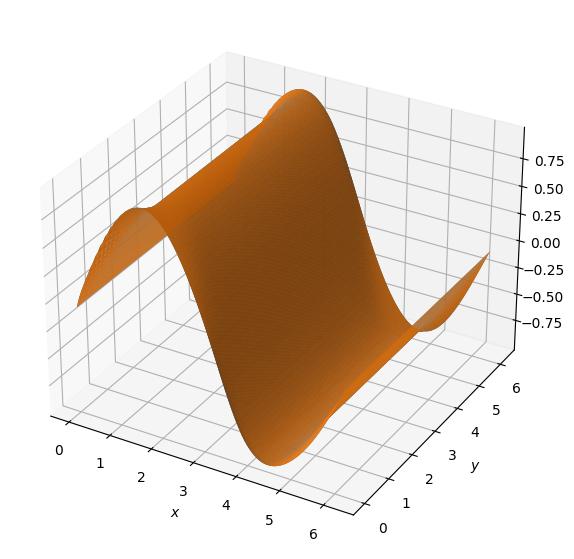

In [70]:
fig = plt.figure(figsize=(11, 7), dpi=100)
ax = fig.add_subplot(projection='3d')
X, Y = np.meshgrid(x, y)
ax.plot_surface(X, Y, u[1:-1], rstride=1, cstride=1)
ax.plot_surface(X, Y, v[1:-1], rstride=1, cstride=1)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

In [71]:
u, v = diff_solver(2*np.pi, 100, 100, 20, 0.1, 0.01, 'sawtooth', 'second order')

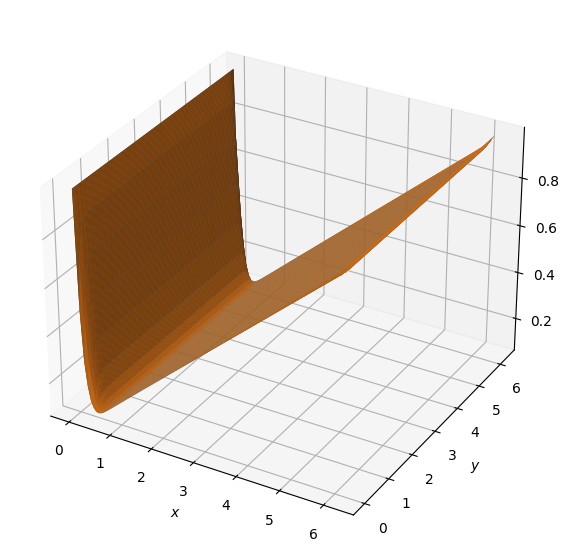

In [72]:
fig = plt.figure(figsize=(11, 7), dpi=100)
ax = fig.add_subplot(projection='3d')
X, Y = np.meshgrid(x, y)
ax.plot_surface(X, Y, u[1:-1], rstride=1, cstride=1)
ax.plot_surface(X, Y, v[1:-1], rstride=1, cstride=1)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

In [73]:
u, v = diff_solver(2*np.pi, 100, 100, 100, 0.1, 0.01, 'rarefaction', 'second order')

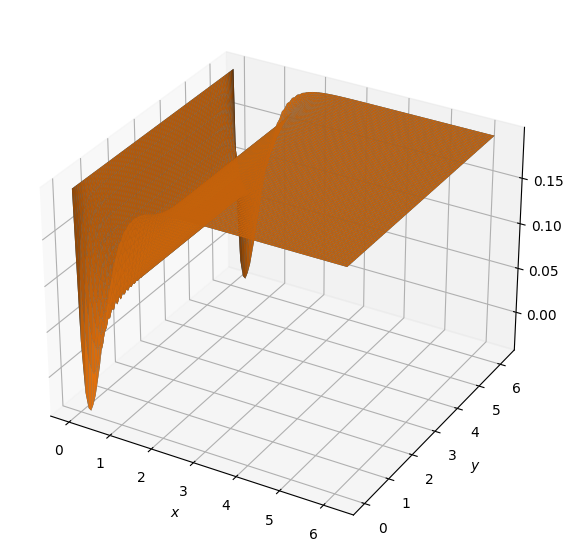

In [74]:
fig = plt.figure(figsize=(11, 7), dpi=100)
ax = fig.add_subplot(projection='3d')
X, Y = np.meshgrid(x, y)
ax.plot_surface(X, Y, u[1:-1], rstride=1, cstride=1)
ax.plot_surface(X, Y, v[1:-1], rstride=1, cstride=1)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

The advective terms in the Burgers' equation represent the transport of fluid by the fluid itself.  The diffusive terms represent the spreading out or smoothing of the flow due to viscosity.

The initial conditions can significantly affect the behavior of the advective term. If the initial velocity field has large gradients or sharp variations, the advective term will dominate flow dynamics.  If, for example, the initial conditions include discontinuities or sharp gradients in velocity, the nonlinear advection term can lead to the formation of shocks.  Advective term behavior depends on the direction and magnitude of the velocity field. If the initial velocity field is predominantly in one direction, the advection term in that direction will dominate the evolution of the flow.
The initial conditions also affect the behavior of the viscous term. If the initial velocity field has smooth variations and small gradients, the viscous term becomes more significant compared to the advective term.  When the initial velocity field is smooth, the viscous term acts to smooth out the flow and dampen any oscillations or sharp gradients present in the velocity field.  However, if the initial conditions contain small-scale features or fluctuations, the viscous term will primarily dissipate energy at those scales, leading to the diffusion of vortices and the decay of turbulent structures.

In summary, the initial conditions play a crucial role in determining the relative importance of the advective and viscous terms in the 2D viscous Burgers' equation. Sharp gradients and discontinuities in the initial velocity field enhance the significance of the advective term, leading to the formation of nonlinear features, while smooth initial conditions emphasize the role of viscosity in smoothing out the flow and damping turbulent fluctuations.